## Package imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import string
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pyarrow
import pickle

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = list(stopwords.words('english'))
#stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define functions

In [3]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    df.text=df.text.apply(lambda x: str(x).replace("X",""))
    df.text=df.text.apply(lambda x: str(x).replace("XX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXXX",""))
    df.text=df.text.apply(lambda x: str(x).replace("XXXXXXXX","")) # removes redactions 

    stopword_dict= set(stopwords.words('english'))

    def sw_remover(arr):
        res=[]
        for i in arr:
            if i not in stopword_dict:
                res.append(i)
        return res

    # def digit_remover(arr):
    #     res=[]
    #     for i in arr:
    #         if i.isdigit()==False:
    #             res.append(i)
    #     return res

    def lemmatizer(arr):
        lem=nltk.stem.WordNetLemmatizer()
        res=[lem.lemmatize(i) for i in arr]
        return res

    def joiner(arr):
        if len(arr)==0:
            return ''
        elif len(arr)==1:
            return arr[0]
        else:
            return ' '.join(arr)
    
    df.text=df.text.apply(lambda x: re.sub(r'\[rnt]',"",x))
    df.text=df.text.apply(lambda x: x.lower())
    df.text=df.text.apply(lambda x: x.split())
    df.text=df.text.apply(sw_remover)
    df.text=df.text.apply(lemmatizer)
    df.text=df.text.apply(joiner)

    df['len']=df['text'].apply(len)
    
    return df

In [ ]:
# #L = WordNetLemmatizer()
# s = SnowballStemmer('english')

# def wordPreProcess(sentence):
#     return ' '.join([s.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])

In [4]:
def getTextFeatures(df, txt, max_features=5000, ngrams=(1,2), verbose=True): #, max_features=10000
    if verbose:
        print('processing: ', txt)
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 #preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
    X = vectorizer.fit_transform(df[txt])
    return X, vectorizer.get_feature_names_out()

## Import FEATURE-ENGINEERED data from EDA

In [5]:
data = pd.read_parquet('./input/dataframes/df_train_FE.parquet')
data.head(10)

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0
5,after more than 7 years from the date of our d...,1,1,0,0.005538,0,1,0.111988,0,0.004298,0,1,0.098837,0,0,0.016295,0,0.016786,0,0,0.004106,0,0,0,1,0,0,0,1,0,0,0
6,"On XXXX XXXX 2014, a car dealership ran my cre...",1,0,1,-1.000000,1,0,0.124968,0,0.039518,0,0,-1.000000,1,0,0.062334,0,0.007891,0,1,0.001262,0,0,1,0,0,0,0,1,0,0,0
7,Received a promotional offer to deposit XXXX f...,1,0,0,-1.000000,1,0,0.012766,0,-1.000000,1,0,0.287679,0,0,0.052776,0,0.018711,0,0,0.001240,0,0,1,0,0,0,0,0,0,1,0
8,I signed up for the promotional rate of 0 % on...,1,0,0,-1.000000,1,0,0.005816,1,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.148084,0,0,0.007570,0,0,1,0,0,0,0,1,0,0,0
9,Scottrade Bank Manager XXXX XXXX XXXX instruct...,1,1,0,0.057181,0,0,0.033231,0,-1.000000,1,0,-1.000000,1,0,0.002694,1,0.148084,0,0,0.003229,0,0,1,0,0,0,1,0,0,0,0


In [6]:
# save data to df so won't have to reload data if need to start over with df.
df_train = data.copy()

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           46764 non-null  object 
 1   timely_response                        46764 non-null  int32  
 2   consumer_disputed?                     46764 non-null  int32  
 3   days_between_receipt_and_sent          46764 non-null  int64  
 4   sub_product_freq                       46764 non-null  float64
 5   sub_product_null_flag                  46764 non-null  int32  
 6   sub_product_low_flag                   46764 non-null  int32  
 7   issue_freq                             46764 non-null  float64
 8   issue_low_flag                         46764 non-null  int32  
 9   sub_issue_freq                         46764 non-null  float64
 10  sub_issue_null_flag                    46764 non-null  int32  
 11  su

In [8]:
df_train.shape

(46764, 32)

In [9]:
list(df_train.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

## Import label-encoded target

In [10]:
y_train_LE = pd.read_parquet('./input/y_targets/y_train_LE.parquet')

In [11]:
product_train = y_train_LE['label'].value_counts()
print(product_train)

4     12286
6     10443
3      8768
2      5550
0      3998
1      2575
10     1490
9       603
8       508
5       466
7        77
Name: label, dtype: int64


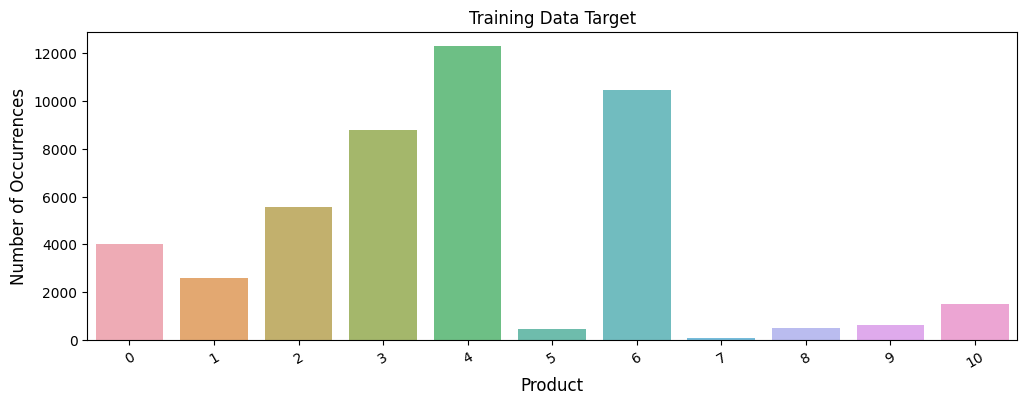

In [12]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_train.index, y=product_train.values, alpha=0.8) 
plt.title('Training Data Target')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [13]:
for i in df_train['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

Dear Sir or Madam, Ever since XXXX XXXX XXXX sold our Mortgage Loan to XXXX, we have had nothing but problems. My husband and I back in 2009, tried to modify the loan. This was an absolute nightmare. After submitting information several times and going through numerous " scheduling '' of calls with Loan counselors, who when I finally got to talk to them, had nothing of substance to discuss or help me with and offered no guidance or help. They would tell me that I needed to get certain pieces of info. and schedule yet another call ( which were always 2 weeks later ) and take it from there, then it was like XXXX XXXX XXXX ... .. I would schedule call after call just to discuss separate pieces of my Loan Mod. Application. It made NO SENSE! I got nowhere and gave up. I have a file 3 inches thick with my application, with forms and notes and all the back up info that I scanned to them, which they claimed to never have received ... .. I finally gave up. With my husband laid off due the const

In [14]:
df_train = df_train.rename({'consumer_complaint_narrative':'text'},axis=1)

In [15]:
df_train['text'] = df_train['text'].astype(str)

In [16]:
df_train.head()

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0


## Sanitize and vectorize text

In [17]:
df_train = clean_text(df_train)

In [18]:
X_text_train, feat_text_train = getTextFeatures(df_train, 'text')

processing:  text


In [19]:
print(X_text_train)

  (0, 3177)	0.09985454561129845
  (0, 2399)	0.06621323730245418
  (0, 1768)	0.10817096642124747
  (0, 450)	0.10061329710739629
  (0, 1625)	0.09667286567210835
  (0, 2538)	0.09673981699408102
  (0, 2142)	0.10694644485189596
  (0, 3239)	0.08798809988040521
  (0, 3252)	0.08937440957978372
  (0, 4118)	0.08606885566294341
  (0, 3235)	0.10734382700324596
  (0, 4821)	0.09208918436663632
  (0, 4402)	0.09680706260852448
  (0, 3273)	0.07533181566201506
  (0, 4949)	0.0766268653549568
  (0, 2793)	0.0964737519808114
  (0, 3243)	0.0810941408606731
  (0, 1628)	0.10498557554143184
  (0, 1143)	0.10694644485189596
  (0, 2555)	0.0925413853473502
  (0, 2464)	0.09005256393799303
  (0, 3594)	0.06261273088213878
  (0, 1608)	0.10655912409693213
  (0, 4051)	0.09062659544718694
  (0, 3289)	0.07993285877228277
  :	:
  (46763, 1227)	0.08650906908643367
  (46763, 2932)	0.07364658837501929
  (46763, 3144)	0.09975170376497083
  (46763, 863)	0.10252483022040564
  (46763, 3142)	0.10099298601627833
  (46763, 4157)	0.08

In [20]:
#Saving the training text features into an NPZ file
sparse.save_npz("./input/X_matrices/tfidf/X_text_train.npz", X_text_train)

## Combine text matrix with engineered features from EDA

In [21]:
# get engineered features together in place
numFeatures =['timely_response', 'consumer_disputed?', 'days_between_receipt_and_sent',
              'sub_product_freq', 'sub_product_null_flag', 'sub_product_low_flag', 'issue_freq',
              'issue_low_flag', 'sub_issue_freq','sub_issue_null_flag', 'sub_issue_low_flag',
              'company_public_response_freq', 'company_public_response_null_flag', 'company_public_response_low_flag',
              'company_freq', 'company_low_flag', 'state_freq', 'state_null_flag', 'state_low_flag',
              'zipcode_freq', 'zipcode_null_flag', 'zipcode_low_flag', 'Not Older American, Not Servicemember',
              'Older American', 'Older American, Servicemember', 'Servicemember', 'Closed', 'Closed with explanation',
              'Closed with monetary relief', 'Closed with non-monetary relief', 'Untimely response']

In [22]:
X_train = hstack((X_text_train, StandardScaler().fit_transform(df_train[numFeatures]))).tocsr()

In [23]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/tfidf/X_train.npz", X_train)

In [24]:
y_train = y_train_LE['label'].values
print(X_train.shape)
print(y_train.shape)

(46764, 5031)
(46764,)


## Load validation dataset for model evaluation

In [25]:
X_val = sparse.load_npz("./input/X_matrices/tfidf/X_val.npz")

In [26]:
y_val_LE = pd.read_parquet("./input/y_targets/y_val_LE.parquet")

In [27]:
y_val = y_val_LE['label'].values

## Baseline Classification Model with Logistic Regression

In [28]:
# Baseline label classifier with logistic regression - minimal params

log_base = LogisticRegression(
    max_iter=10000,
    random_state=2022
)

log_base.fit(X_train, y_train)

y_pred = log_base.predict(X_val)
print('Testing accuracy %s' % accuracy_score(y_val, y_pred))
print('Testing f1 score %s' % f1_score(y_val, y_pred, average='weighted'))
cm_log_base = confusion_matrix(y_val, y_pred)
cr_log_base = pd.DataFrame(classification_report(y_val, y_pred, zero_division=1, output_dict=True)).T
cr_log_base

Testing accuracy 0.9104711668686293
Testing f1 score 0.909222933038


,precision,recall,f1-score,support
0,0.683650,0.749791,0.715195,1199.000000
1,0.616708,0.650259,0.633039,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.946272,0.998644,0.971753,3686.000000
5,0.555556,0.678571,0.610932,140.000000
6,0.949640,0.884775,0.916061,3133.000000
7,0.000000,0.000000,0.000000,23.000000
8,0.905325,1.000000,0.950311,153.000000
9,0.681416,0.850829,0.756757,181.000000


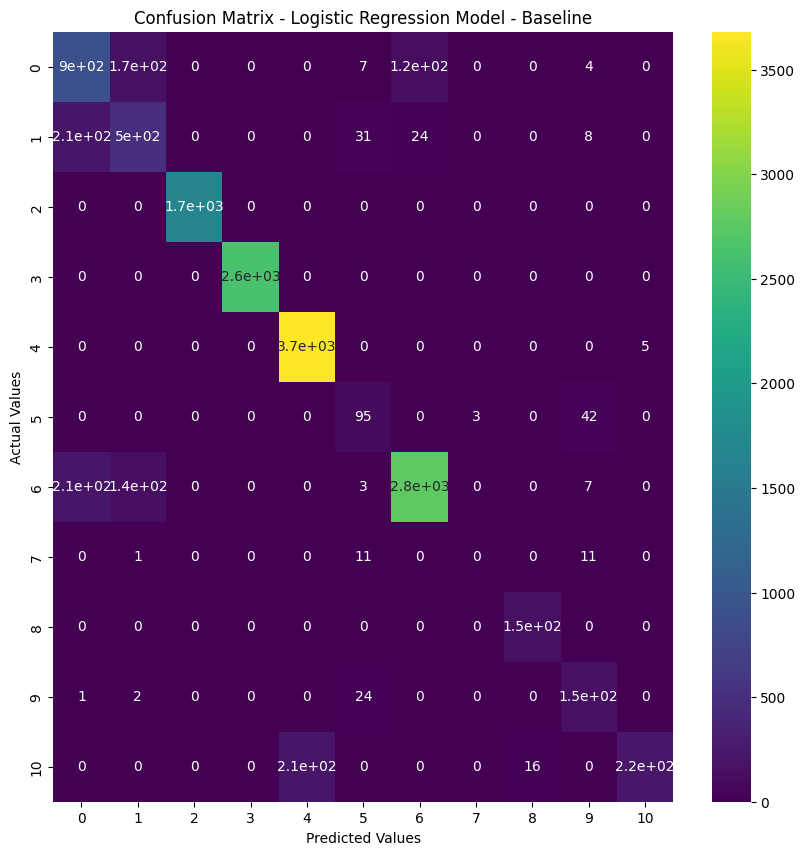

In [29]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log_base, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression Model - Baseline')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Baseline logistic regression performs well with accuracy and f1 score ~91% on the validation dataset.  This may be a difficult baseline to beat - not a bad problem to have ;)
- ### There are a high degree of misclassifications predicting Class 0 for Classes 6 and 1; likewise, Class 1 for Classes 6 and 0; Class 6 for Class 0; and Class 4 for Class 10.
- ### Class 2 (with 1665 samples) and Class 3 (with 2630 samples) were both correctly predicted every time for perfect precision, recall, and f1 scores.
- ### Class 7 with the least amount of support (23 samples) was not correctly predicted once.  Class 7 was only predicted 3 other times and incorrectly.

# Try hyperparameter optimization for the logistic regression model

In [30]:
# Optimize logistic regression classifier with optuna
def log_objective(trial):
    #penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]) #use defaut l2 penalty
    tol = trial.suggest_float("tol", 0.0001, 0.0091, step=0.001, log=False)
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    #fit_intercept = trial.suggest_categorical("fit_intercept", ["True", "False"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"]) #"liblinear", 
    #l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0, step=0.1, log=False) ## only used by elasticnet
        
    ## Create Model
    log = LogisticRegression(tol=tol, C=C, class_weight=class_weight, solver=solver,
                            max_iter=10000, multi_class = "multinomial", random_state = 2022) #fit_intercept=fit_intercept, l1_ratio=l1_ratio, warm_start=True
    ## Fit Model
    log.fit(X_train, y_train)

    return accuracy_score(y_val, log.predict(X_val))

In [31]:
log_study = optuna.create_study(study_name="Logistic Regression Classifier", direction="maximize")
log_study.optimize(log_objective, n_trials=10)

[I 2023-01-10 21:23:29,065] A new study created in memory with name: Logistic Regression Classifier
[I 2023-01-10 21:24:12,038] Trial 0 finished with value: 0.8736902131299451 and parameters: {'tol': 0.0091, 'C': 0.4, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.8736902131299451.
[I 2023-01-10 21:26:55,189] Trial 1 finished with value: 0.9104711668686293 and parameters: {'tol': 0.0031, 'C': 1.0, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9104711668686293.
[I 2023-01-10 21:27:54,856] Trial 2 finished with value: 0.8784660346425262 and parameters: {'tol': 0.0071, 'C': 0.4, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 1 with value: 0.9104711668686293.
[I 2023-01-10 21:29:08,302] Trial 3 finished with value: 0.8826716088103215 and parameters: {'tol': 0.0041, 'C': 0.9, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 1 with value: 0.9104711668686293.
[I 2023-01-10 21:29:36,492] Trial 4 finished with val

In [32]:
print("Best Params: {}".format(log_study.best_params))
print("\nBest Accuracy: {}".format(log_study.best_value))

Best Params: {'tol': 0.0031, 'C': 1.0, 'class_weight': None, 'solver': 'lbfgs'}

Best Accuracy: 0.9104711668686293


In [33]:
log_clf = LogisticRegression(**log_study.best_params, max_iter=10000, multi_class = "multinomial", random_state = 2022)
log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_val = log_clf.predict(X_val)

log_train_acc = accuracy_score(y_train, y_pred_train)
log_val_acc = accuracy_score(y_val, y_pred_val)

log_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
log_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Logistic Regression Accuracy on Train Dataset: {}".format(log_train_acc))
print("\nLogistic Regression Accuracy on Validation Dataset: {}".format(log_val_acc))
print("\n#####################")
print("\nLogistic Regression F1 Score on Train Dataset: {}".format(log_train_f1))
print("\nLogistic Regression F1 Score on Validation Dataset: {}".format(log_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_log = confusion_matrix(y_val, y_pred_val)
cr_log = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_log

Logistic Regression Accuracy on Train Dataset: 0.9906124369172868

Logistic Regression Accuracy on Validation Dataset: 0.9104711668686293

#####################

Logistic Regression F1 Score on Train Dataset: 0.9905032706133067

Logistic Regression F1 Score on Validation Dataset: 0.909222933038


,precision,recall,f1-score,support
0,0.683650,0.749791,0.715195,1199.000000
1,0.616708,0.650259,0.633039,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.946272,0.998644,0.971753,3686.000000
5,0.555556,0.678571,0.610932,140.000000
6,0.949640,0.884775,0.916061,3133.000000
7,0.000000,0.000000,0.000000,23.000000
8,0.905325,1.000000,0.950311,153.000000
9,0.681416,0.850829,0.756757,181.000000


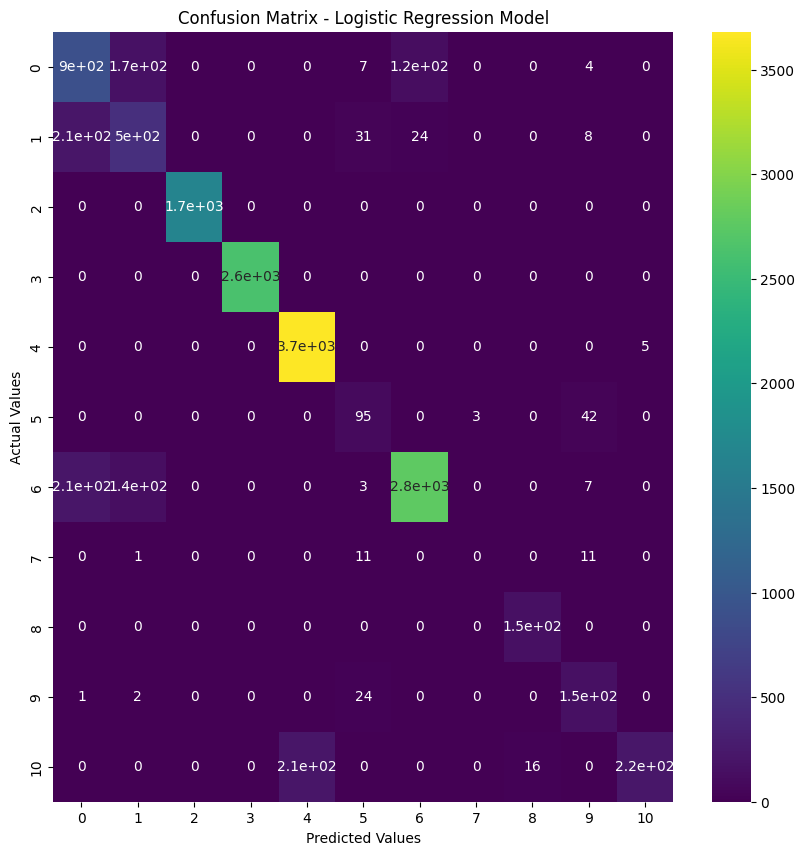

In [34]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Hyperparameter optimization with Optuna did not improve the validation accuracy and f1 score much from the logistic regression classifier baseline.
- ### Classification heatmap demonstrates fairly good classification overall but there are a high degree of misclassifications predicting Class 0 for Classes 6 and 1; likewise, Class 1 for Classes 6 and 0; Class 6 for Class 0; and Class 4 for Class 10 - similar to the baseline. 
- ### Classifier had some smaller confusion issues predicting Class 5 for Classes 1 and 9; likewise, Class 9 for Class 5; and Class 6 for Class 1.
- ### Class 7 with the least amount of support (23 samples) was not correctly predicted once.  Class 7 was only predicted 3 other times and incorrectly - similar to the baseline.
- ### Class 2 (with 1665 samples) and Class 3 (with 2630 samples) were both correctly predicted every time for perfect precision, recall, and f1 scores.
- ### Overfitting with this model is a concern since the metrics on the training data are much higher than the validation data - similar to the baseline.

# Try other classification model types with hyperparameter optimization

## Passive Aggressive Classifier

In [35]:
# Optimize passive aggressive classifier with optuna
def pac_objective(trial):
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    tol = trial.suggest_float("tol", 0.001, 0.01, step=0.001, log=False)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
            
    ## Create Model
    pac = PassiveAggressiveClassifier(C=C, tol=tol, loss=loss, class_weight=class_weight, 
                                        max_iter=10000, random_state = 2022) 

    ## Fit Model
    pac.fit(X_train, y_train)

    return accuracy_score(y_val, pac.predict(X_val))

In [36]:
pac_study = optuna.create_study(study_name="Passive Aggressive Classifier", direction="maximize")
pac_study.optimize(pac_objective, n_trials=10)

[I 2023-01-10 21:35:09,023] A new study created in memory with name: Passive Aggressive Classifier
[I 2023-01-10 21:35:12,327] Trial 0 finished with value: 0.5357473804262599 and parameters: {'C': 1.0, 'tol': 0.002, 'loss': 'squared_hinge', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5357473804262599.
[I 2023-01-10 21:35:14,472] Trial 1 finished with value: 0.8785373155606244 and parameters: {'C': 0.7000000000000001, 'tol': 0.004, 'loss': 'squared_hinge', 'class_weight': None}. Best is trial 1 with value: 0.8785373155606244.
[I 2023-01-10 21:35:16,878] Trial 2 finished with value: 0.5470810464038777 and parameters: {'C': 0.5, 'tol': 0.005, 'loss': 'squared_hinge', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8785373155606244.
[I 2023-01-10 21:35:18,975] Trial 3 finished with value: 0.5470810464038777 and parameters: {'C': 0.5, 'tol': 0.005, 'loss': 'squared_hinge', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8785373155606244.
[I 2023-01-10 21

In [37]:
print("Best Params: {}".format(pac_study.best_params))
print("\nBest Accuracy: {}".format(pac_study.best_value))

Best Params: {'C': 0.6, 'tol': 0.009000000000000001, 'loss': 'hinge', 'class_weight': None}

Best Accuracy: 0.8848100363532683


In [38]:
pac_clf = PassiveAggressiveClassifier(**pac_study.best_params, max_iter=10000, random_state = 2022)
pac_clf.fit(X_train, y_train)

y_pred_train = pac_clf.predict(X_train)
y_pred_val = pac_clf.predict(X_val)

pac_train_acc = accuracy_score(y_train, y_pred_train)
pac_val_acc = accuracy_score(y_val, y_pred_val)

pac_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
pac_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Passive Aggressive Classifier Accuracy on Train Dataset: {}".format(pac_train_acc))
print("\nPassive Aggressive Classifier Accuracy on Validation Dataset: {}".format(pac_val_acc))
print("\n#####################")
print("\nPassive Aggressive Classifier F1 Score on Train Dataset: {}".format(pac_train_f1))
print("\nPassive Aggressive Classifier F1 Score on Validation Dataset: {}".format(pac_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_pac = confusion_matrix(y_val, y_pred_val)
cr_pac = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_pac

Passive Aggressive Classifier Accuracy on Train Dataset: 0.9839834060388333

Passive Aggressive Classifier Accuracy on Validation Dataset: 0.8848100363532683

#####################

Passive Aggressive Classifier F1 Score on Train Dataset: 0.9840921238278799

Passive Aggressive Classifier F1 Score on Validation Dataset: 0.8830846124071151


,precision,recall,f1-score,support
0,0.671066,0.551293,0.605311,1199.00000
1,0.603960,0.553109,0.577417,772.00000
2,0.998201,1.000000,0.999100,1665.00000
3,1.000000,1.000000,1.000000,2630.00000
4,0.939871,0.988063,0.963365,3686.00000
5,0.345455,0.678571,0.457831,140.00000
6,0.885976,0.895308,0.890618,3133.00000
7,0.078125,0.217391,0.114943,23.00000
8,0.780612,1.000000,0.876791,153.00000
9,0.550505,0.602210,0.575198,181.00000


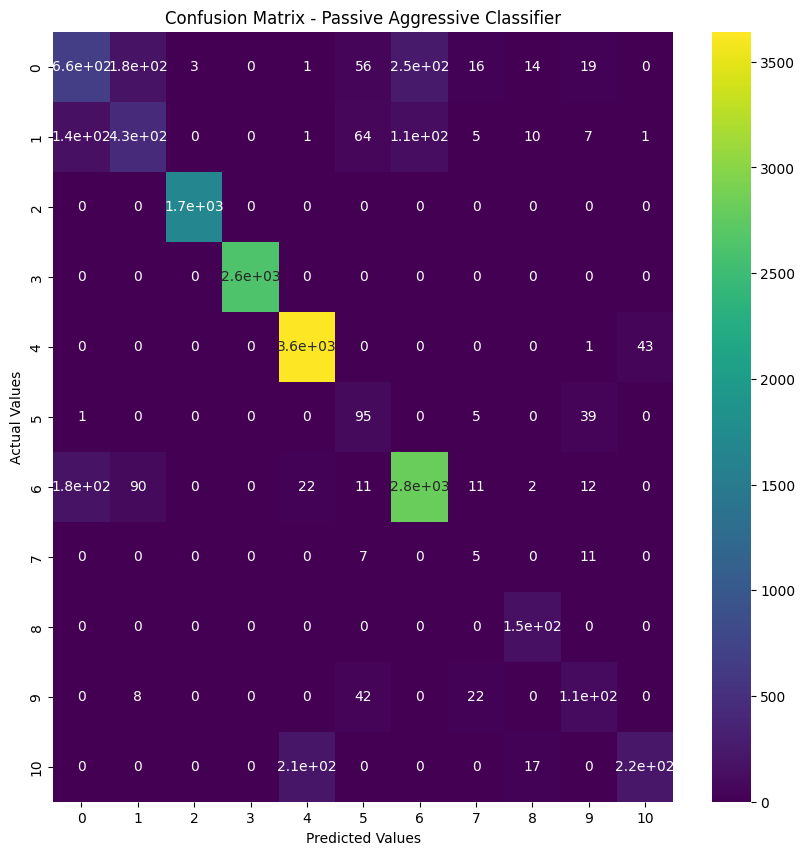

In [39]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_pac, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Passive Aggressive Classifier exhibited slightly lower validation accuracy and f1 score than the Logistic Regression Classifier.
- ### Classification heatmap demonstrates fairly good classification overall but there are a high degree of misclassifications predicting Class 0 for Classes 6 and 1; likewise, Class 6 for Classes 0 and 1 & Class 1 for Class 0; and Class 4 for Class 10 - similar to the baseline. 
- ### Similar to the Logistic Regression Classifier, the Passive Aggressive Classifier had some smaller confusion issues predicting Class 1 for Class 6; Class 4 for Class 6; Class 5 for Classes 0, 1, and 9; Class 7 for Class 9; Class 9 for Class 5; and Class 10 for Class 4. 
- ### Class 7 with the least amount of support (23 samples) was only correctly predicted 5 times.  Class 7 was predicted 59 other times and incorrectly.
- ### Class 3 (with 2630 samples) was correctly predicted every time for a perfect precision, recall, and f1 score.
- ### Overfitting with this model is a concern since the metrics on the training data are much higher than the validation data - similar to the baseline.

## Random Forest Classifier

In [40]:
# Optimize Random Forest Classifier with optuna
def rfc_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 550, step=100, log=False)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 10, step=2, log=False)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 100, step=20, log=False)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 50, step=10, log=False)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
            
    ## Create Model
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, 
                                    class_weight=class_weight, random_state = 2022) 

    ## Fit Model
    rfc.fit(X_train, y_train)

    return accuracy_score(y_val, rfc.predict(X_val))

In [41]:
rfc_study = optuna.create_study(study_name="Random Forest Classifier", direction="maximize")
rfc_study.optimize(rfc_objective, n_trials=10)

[I 2023-01-10 21:35:33,703] A new study created in memory with name: Random Forest Classifier
[I 2023-01-10 21:35:44,303] Trial 0 finished with value: 0.8264309644308219 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 80, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8264309644308219.
[I 2023-01-10 21:50:17,327] Trial 1 finished with value: 0.45192102074274715 and parameters: {'n_estimators': 550, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8264309644308219.
[I 2023-01-10 21:50:33,521] Trial 2 finished with value: 0.6700406301233159 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': 

In [42]:
print("Best Params: {}".format(rfc_study.best_params))
print("\nBest Accuracy: {}".format(rfc_study.best_value))

Best Params: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 100, 'min_samples_leaf': 30, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}

Best Accuracy: 0.9586570675030295


In [43]:
rfc_clf = RandomForestClassifier(**rfc_study.best_params, random_state = 2022)
rfc_clf.fit(X_train, y_train)

y_pred_train = rfc_clf.predict(X_train)
y_pred_val = rfc_clf.predict(X_val)

rfc_train_acc = accuracy_score(y_train, y_pred_train)
rfc_val_acc = accuracy_score(y_val, y_pred_val)

rfc_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
rfc_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Validation Dataset: {}".format(rfc_val_acc))
print("\n#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Validation Dataset: {}".format(rfc_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_val, y_pred_val)
cr_rfc = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.9716234710461038

Random Forest Classifier Accuracy on Validation Dataset: 0.9586570675030295

#####################

Random Forest Classifier F1 Score on Train Dataset: 0.9734142325886591

Random Forest Classifier F1 Score on Validation Dataset: 0.9589434125844104


,precision,recall,f1-score,support
0,0.908319,0.892410,0.900294,1199.000000
1,0.709213,0.957254,0.814774,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,1.000000,0.988877,0.994407,3686.000000
5,0.530000,0.378571,0.441667,140.000000
6,1.000000,0.944462,0.971438,3133.000000
7,0.272727,0.652174,0.384615,23.000000
8,1.000000,1.000000,1.000000,153.000000
9,0.640351,0.403315,0.494915,181.000000


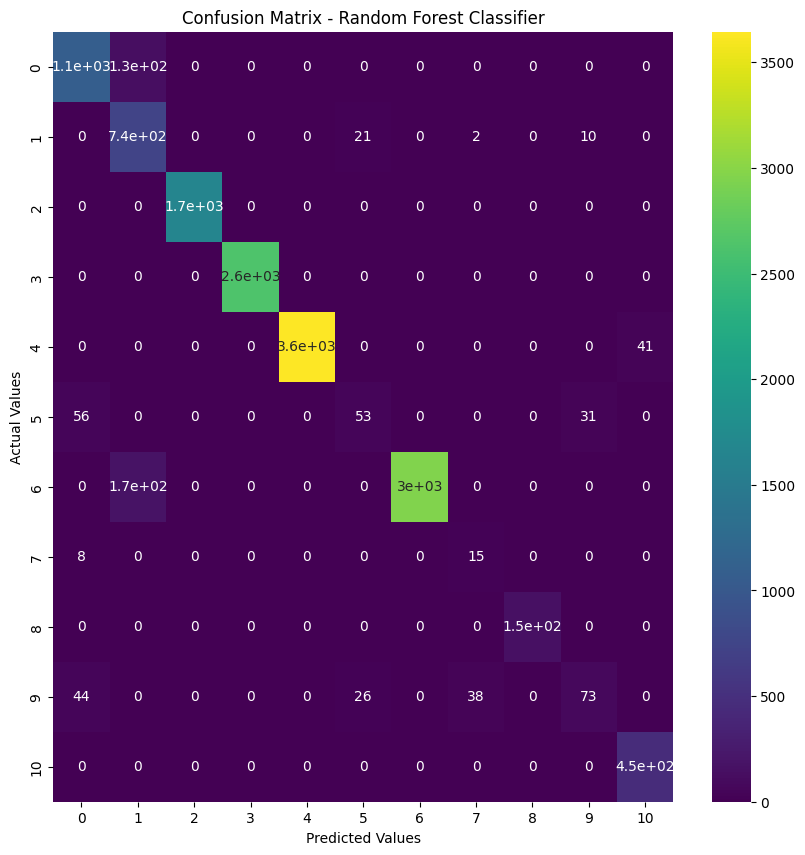

In [44]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier performed much better than the Logistic Regression and Passive Aggressive Classifiers with validation accuracy and f1 score, ~96%.
- ### Classification heatmap demonstrates very good classification overall but a high degree of misclassifications predicting Class 1 for Classes 6 and 0.
- ### This classifier had some smaller confusion issues predicting Class 0 for Classes 5 and 9; Class 5 for Classes 9 and 1; Class 7 for Class 9; Class 9 for Class 5; and Class 10 for Class 4.
- ### Class 7 with least amount of support (23 samples) was correctly predicted 15 times for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly 40 times.
- ### Class 2 (with 1665 samples), Class 3 (with 2630 samples), and Class 8 (with 153 samples) were each correctly predicted every time for perfect precision, recall, and f1 scores.
- ### There is very marginal evidence of small amount of overfitting with slightly higher metrics on the training data than the validation data.

## XGBoost Classifier

In [45]:
# Optimize XGBoost Classifier with optuna   ## may be better to use xgboost w/o any hyperparams/optuna to overfit and then regularize after to reduce overfit
def xgb_objective(trial):
    #booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    eta = trial.suggest_float("eta", 0.1, 1.0, step=0.1, log=False)
    gamma = trial.suggest_int("gamma", 0, 100, step=10, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 42, step=4, log=False)
    min_child_weight = trial.suggest_int("min_child_weight", 0, 50, step=10, log=False)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1, log=False)
    #sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]) #gradient_based only for tree_method: gpu_hist
            
    ## Create Model
    xgb = XGBClassifier(booster="gbtree", eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, 
                            subsample=subsample, eval_metric="mlogloss", use_label_encoder=False, random_state = 2022) # booster=booster, sampling_method=sampling_method,

    ## Fit Model
    xgb.fit(X_train, y_train)

    return accuracy_score(y_val, xgb.predict(X_val))

In [46]:
xgb_study = optuna.create_study(study_name="XGBoost Classifier", direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10)

[I 2023-01-10 22:18:08,294] A new study created in memory with name: XGBoost Classifier
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-01-10 22:19:50,681] Trial 0 finished with value: 0.9523843467103856 and parameters: {'eta': 0.4, 'gamma': 90, 'max_depth': 30, 'min_child_weight': 10, 'subsample': 1.0}. Best is trial 0 with value: 0.9523843467103856.
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-01-10 22:24:12,408] Trial 1 finished with value: 0.9580155392401454 and parameters: {'eta': 0.5, 'gamma': 30, 'max_depth': 34, 'min_child_weight': 0, 'subsample': 1.0}. Best is trial 1 with value: 0.9580155392401454.
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encod

In [47]:
print("Best Params: {}".format(xgb_study.best_params))
print("\nBest Accuracy: {}".format(xgb_study.best_value))

Best Params: {'eta': 0.9, 'gamma': 0, 'max_depth': 22, 'min_child_weight': 40, 'subsample': 0.6}

Best Accuracy: 0.9806115902772827


In [48]:
xgb_clf = XGBClassifier(**xgb_study.best_params, booster="gbtree", use_label_encoder=False, eval_metric="mlogloss", random_state = 2022)
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_val = xgb_clf.predict(X_val)

xgb_train_acc = accuracy_score(y_train, y_pred_train)
xgb_val_acc = accuracy_score(y_val, y_pred_val)

xgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
xgb_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Validation Dataset: {}".format(xgb_val_acc))
print("\n#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Validation Dataset: {}".format(xgb_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_val, y_pred_val)
cr_xgb = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_xgb

c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Classifier Accuracy on Train Dataset: 0.9983320502950987

XGBoost Classifier Accuracy on Validation Dataset: 0.9806115902772827

#####################

XGBoost Classifier F1 Score on Train Dataset: 0.9983204174914841

XGBoost Classifier F1 Score on Validation Dataset: 0.9810984906860781


,precision,recall,f1-score,support
0,0.897436,0.992494,0.942574,1199.000000
1,0.974093,0.974093,0.974093,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,0.999620,1.000000,0.999810,2630.000000
4,1.000000,0.989962,0.994956,3686.000000
5,0.950820,0.828571,0.885496,140.000000
6,0.992190,0.973189,0.982597,3133.000000
7,0.255556,1.000000,0.407080,23.000000
8,0.973856,0.973856,0.973856,153.000000
9,0.967742,0.497238,0.656934,181.000000


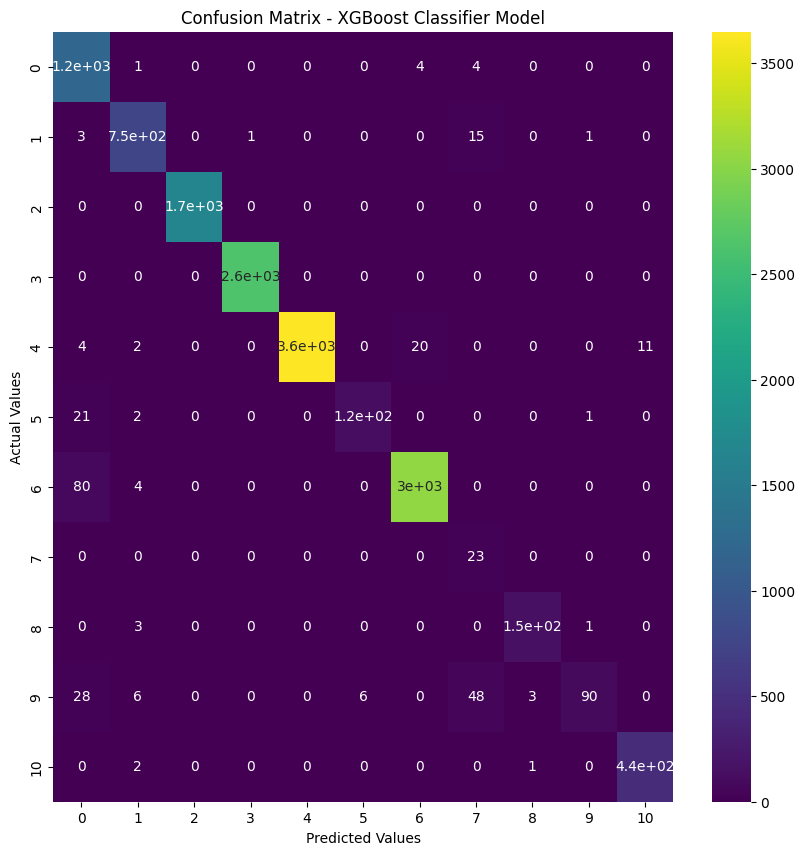

In [49]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - XGBoost Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### XGBoost Classifier performed slightly better than the Random Forest Classifier with slightly better validation accuracy and f1 score, ~98%.
- ### Classification heatmap demonstrates extremely good classification overall. 
- ### This classifier had some small confusion issues predicting Class 0 for Classes 6, 9, and 5; Class 6 for Class 4; and Class 7 for Class 9.
- ### Class 7 with least amount of support (23 samples) was correctly predicted every time for a perfect recall score.  However, Class 7 was also predicted incorrectly 67 times.
- ### Class 2 (with 1665 samples) was correctly predicted every time for a perfect precision, recall, and f1 score.
- ### There is marginal evidence of some amount of overfitting with near perfect metrics on the training data, however, there is not much room for difference when the metrics on the validation data are also very high.

## LightGBM Classifier

In [50]:
# Optimize LightGBM Classifier Classifier with optuna
def lgb_objective(trial):
    #boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss", "rf"])
    num_leaves = trial.suggest_int("num_leaves", 4, 20, step=4, log=False) #decrease
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2, log=False) #decrease
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.010, step=0.001, log=False)
    n_estimators = trial.suggest_int("n_estimators", 350, 500, step=25, log=False) #increase
    min_child_weight = trial.suggest_float("min_child_weight", 0.01, 0.10, step=0.01, log=False) #increase ## may be too high
    min_child_samples = trial.suggest_int("min_child_samples", 100, 200, step=25, log=False) #decrease  ## may be too high
    subsample = trial.suggest_float("subsample", 0.2, 1.0, step=0.2, log=False)
            
    ## Create Model
    lgb = LGBMClassifier(boosting_type="gbdt", num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                            n_estimators=n_estimators, min_child_weight=min_child_weight, min_child_samples=min_child_samples, 
                            subsample=subsample, objective="multiclass", random_state = 2022) #class_weight=class_weights_dict, 

    ## Fit Model
    lgb.fit(X_train, y_train)

    return accuracy_score(y_val, lgb.predict(X_val))

In [51]:
lgb_study = optuna.create_study(study_name="LightGBM Classifier", direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=10)

[I 2023-01-10 22:30:37,892] A new study created in memory with name: LightGBM Classifier
[I 2023-01-10 22:36:30,863] Trial 0 finished with value: 0.9224463611091311 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.003, 'n_estimators': 350, 'min_child_weight': 0.01, 'min_child_samples': 200, 'subsample': 1.0}. Best is trial 0 with value: 0.9224463611091311.
[I 2023-01-10 22:41:02,573] Trial 1 finished with value: 0.8857366882885451 and parameters: {'num_leaves': 8, 'max_depth': 6, 'learning_rate': 0.002, 'n_estimators': 425, 'min_child_weight': 0.09999999999999999, 'min_child_samples': 200, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 0.9224463611091311.
[I 2023-01-10 22:46:07,065] Trial 2 finished with value: 0.9235155748806044 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.01, 'n_estimators': 375, 'min_child_weight': 0.01, 'min_child_samples': 100, 'subsample': 1.0}. Best is trial 2 with value: 0.9235155748806044.
[I 2023-01-

In [52]:
print("Best Params: {}".format(lgb_study.best_params))
print("\nBest Accuracy: {}".format(lgb_study.best_value))

Best Params: {'num_leaves': 12, 'max_depth': 2, 'learning_rate': 0.006, 'n_estimators': 450, 'min_child_weight': 0.02, 'min_child_samples': 100, 'subsample': 0.4}

Best Accuracy: 0.9612944614726637


In [53]:
lgb_clf = LGBMClassifier(**lgb_study.best_params, boosting_type="gbdt", objective="multiclass", random_state = 2022)
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_val = lgb_clf.predict(X_val)

lgb_train_acc = accuracy_score(y_train, y_pred_train)
lgb_val_acc = accuracy_score(y_val, y_pred_val)

lgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
lgb_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("LightGBM Classifier Accuracy on Train Dataset: {}".format(lgb_train_acc))
print("\nLightGBM Classifier Accuracy on Validation Dataset: {}".format(lgb_val_acc))
print("\n#####################")
print("\nLightGBM Classifier F1 Score on Train Dataset: {}".format(lgb_train_f1))
print("\nLightGBM Classifier F1 Score on Validation Dataset: {}".format(lgb_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_lgb = confusion_matrix(y_val, y_pred_val)
cr_lgb = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_lgb

LightGBM Classifier Accuracy on Train Dataset: 0.9937344966213326

LightGBM Classifier Accuracy on Validation Dataset: 0.9612944614726637

#####################

LightGBM Classifier F1 Score on Train Dataset: 0.9937531197869905

LightGBM Classifier F1 Score on Validation Dataset: 0.9592234560104828


,precision,recall,f1-score,support
0,0.877992,0.948290,0.911788,1199.000000
1,0.838524,0.941710,0.887126,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,0.999620,1.000000,0.999810,2630.000000
4,0.983919,0.979381,0.981645,3686.000000
5,0.959184,0.335714,0.497354,140.000000
6,0.983371,0.962656,0.972903,3133.000000
7,0.562500,0.782609,0.654545,23.000000
8,1.000000,0.398693,0.570093,153.000000
9,0.659794,0.707182,0.682667,181.000000


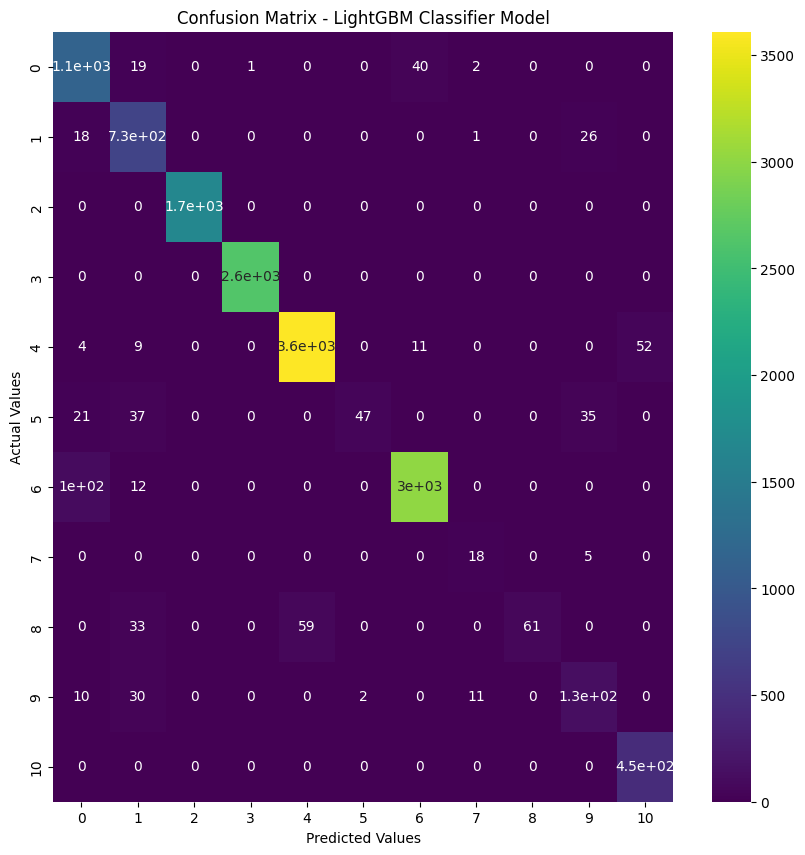

In [54]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - LightGBM Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### LightGBM Classifier performed slightly worse than the XGBoost Classifier with validation accuracy and f1 score of 96%.
- ### Classification heatmap demonstrates very good classification overall but a high degree of misclassifications predicting Class 0 for Class 6.
- ### This classifier had some smaller confusion issues predicting Class 0 for Class 5; Class 1 for Classes 5, 8, and 9; Class 4 for Class 8; Class 6 for Class 0; Class 9 for Classes 5 and 1; and Class 10 for Class 4.
- ### Class 7 with least amount of support (23 samples) was correctly predicted 18 times.  However, Class 7 was also predicted incorrectly 14 times.
- ### Class 2 (with 1665 samples) was correctly predicted every time for a perfect precision, recall, and f1 score.
- ### There is some evidence of overfitting with somewhat higher metrics on the training data than the validation data - slightly higher than XGBoost Classifier.

## Save Models

In [55]:
pickle.dump(log_clf, open('./bin/tfidf/log_clf_trained.pkl', 'wb'))
pickle.dump(pac_clf, open('./bin/tfidf/pac_clf_trained.pkl', 'wb'))
pickle.dump(rfc_clf, open('./bin/tfidf/rfc_clf_trained.pkl', 'wb'))
pickle.dump(xgb_clf, open('./bin/tfidf/xgb_clf_trained.pkl', 'wb'))
pickle.dump(lgb_clf, open('./bin/tfidf/lgb_clf_trained.pkl', 'wb'))

## Ensemble best models together to balance bias-variance tradeoff / mitigate any overfitting.

In [56]:
# load 3 best saved models
rfc_clf = pickle.load(open('./bin/tfidf/rfc_clf_trained.pkl', 'rb'))
xgb_clf = pickle.load(open('./bin/tfidf/xgb_clf_trained.pkl', 'rb'))
lgb_clf = pickle.load(open('./bin/tfidf/lgb_clf_trained.pkl', 'rb'))

In [57]:
ensemble_clf = VotingClassifier(estimators=[('rfc', rfc_clf), ('xgb', xgb_clf), ('lgb', lgb_clf)], 
                                    voting='soft') # can use 'soft' argmax voting since each classifier has predict_proba

In [60]:
ensemble_clf = ensemble_clf.fit(X_train, y_train)

c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [61]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_val_ensemble = ensemble_clf.predict(X_val)

In [62]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_val_acc = accuracy_score(y_val, y_pred_val_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_val_f1 = f1_score(y_val, y_pred_val_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Validation Dataset: {}".format(results_ensemble_val_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Validation Dataset: {}".format(results_ensemble_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_ensemble_val = confusion_matrix(y_val, y_pred_val_ensemble)
cr_ensemble_val = pd.DataFrame(classification_report(y_val, y_pred_val_ensemble, zero_division=1, output_dict=True)).T
cr_ensemble_val

Ensemble Accuracy on Train Dataset: 0.997947138824737

Ensemble Accuracy on Validation Dataset: 0.9741250267303443
#####################

Ensemble F1 Score on Train Dataset: 0.9979900824009957

Ensemble F1 Score on Validation Dataset: 0.9732895942234869


,precision,recall,f1-score,support
0,0.866715,0.992494,0.925350,1199.000000
1,0.972585,0.965026,0.968791,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,1.000000,0.988334,0.994133,3686.000000
5,0.580645,0.385714,0.463519,140.000000
6,1.000000,0.972231,0.985920,3133.000000
7,0.272727,0.652174,0.384615,23.000000
8,1.000000,1.000000,1.000000,153.000000
9,0.678261,0.430939,0.527027,181.000000


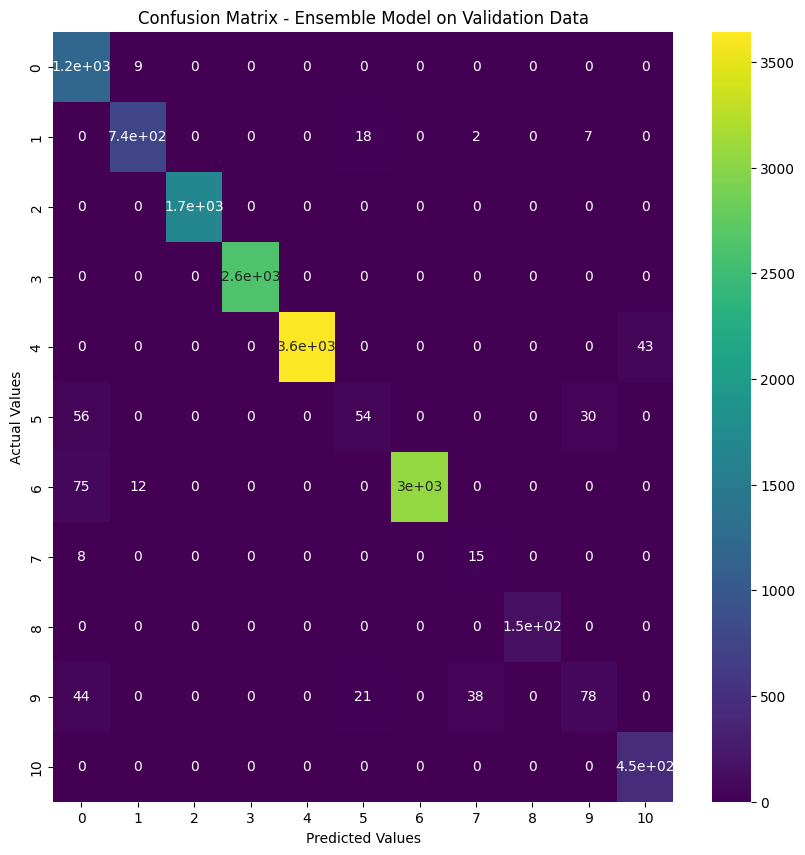

In [63]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_ensemble_val, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Ensemble Model on Validation Data')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Ensemble Model performed slightly worse than the best single model (XGBoost Classifier) in terms of validation accuracy and f1 score.
- ### Classification heatmap demonstrates extremely good classification overall.
- ### This classifier had some small confusion issues predicting Class 0 for Classes 6, 5, and 9; Class 5 for Class 9 (bidirectionally); Class 7 for Class 9; and Class 10 for Class 4.
- ### Class 7 with least amount of support (23 samples) was correctly predicted 15 times.  However, Class 7 was also predicted incorrectly 40 times.
- ### Class 2 (with 1665 samples), Class 3 (with 2630 samples), and Class 8 (with 153 samples) were each correctly predicted every time for perfect precision, recall, and f1 scores.
- ### There is marginal evidence of overfitting (slightly more than XGBoost Classifier) with marginally higher metrics on training data.

## Save ensemble model

In [64]:
pickle.dump(ensemble_clf, open('./bin/tfidf/ensemble_clf_trained.pkl', 'wb'))

## Load out-of-sample test dataset and target for ensemble model evaluation

In [65]:
X_test = sparse.load_npz("./input/X_matrices/tfidf/X_test.npz")

In [66]:
y_test_LE = pd.read_parquet("./input/y_targets/y_test_LE.parquet")

In [67]:
y_test = y_test_LE['label'].values

# Begin ensemble model predictions and evaluation

In [68]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_test_ensemble = ensemble_clf.predict(X_test)

In [69]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("\n#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_ensemble = confusion_matrix(y_test, y_pred_test_ensemble)
cr_ensemble = pd.DataFrame(classification_report(y_test, y_pred_test_ensemble, zero_division=1, output_dict=True)).T
cr_ensemble

Ensemble Accuracy on Train Dataset: 0.997947138824737

Ensemble Accuracy on Test Dataset: 0.9629136870114752

#####################

Ensemble F1 Score on Train Dataset: 0.9979900824009957

Ensemble F1 Score on Test Dataset: 0.9608489331240694


,precision,recall,f1-score,support
0,0.893258,0.928016,0.910305,514.000000
1,0.827763,0.972810,0.894444,331.000000
2,1.000000,1.000000,1.000000,714.000000
3,1.000000,1.000000,1.000000,1128.000000
4,1.000000,0.986076,0.992989,1580.000000
5,0.076923,0.016667,0.027397,60.000000
6,0.996860,0.945644,0.970577,1343.000000
7,0.476190,1.000000,0.645161,10.000000
8,0.955882,1.000000,0.977444,65.000000
9,0.548077,0.740260,0.629834,77.000000


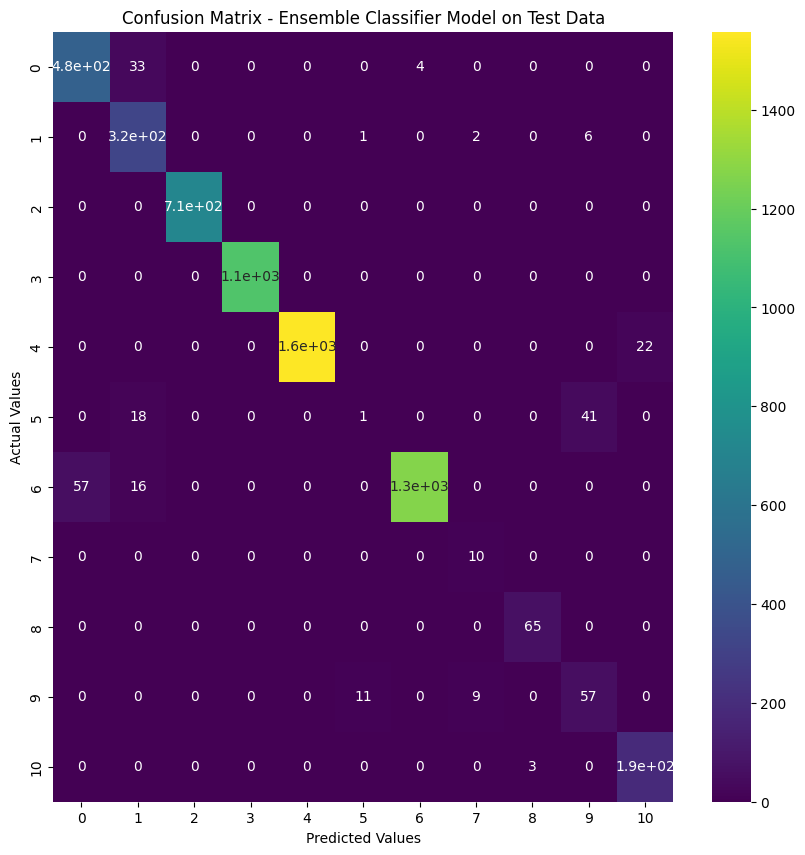

In [70]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_ensemble, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Ensemble Classifier Model on Test Data')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Ensemble Model performed very well on the test data with test accuracy and f1 score of 96%.  This was just slightly worse than the performance on the validation data which had validation accuracy and f1 score of 97%
- ### Classification heatmap demonstrates extremely good classification overall. 
- ### This classifier had some small confusion issues predicting Class 0 for Class 6; Class 1 for Class 0; Class 9 for Class 5; and Class 10 for Class 4.
- ### Class 7 with least amount of support (10 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly 11 times.
- ### Class 2 (with 714 samples) and Class 3 (with 1128 samples) were both correctly predicted every time for perfect precision, recall, and f1 scores.
- ### There is marginal evidence of overfitting (slightly more than XGBoost Classifier) with marginally higher metrics on training data.
- ### The XGBoost Classifier performed the best on the validation data and will also be evaluated on the test dataset.

## Load and compare the XGBoost Classifier performance on the test data since it had the highest validation metrics

In [75]:
# load saved xgboost classifier model
xgb_clf = pickle.load(open('./bin/tfidf/xgb_clf_trained.pkl', 'rb'))

In [77]:
y_pred_train_xgb = xgb_clf.predict(X_train)
y_pred_test_xgb = xgb_clf.predict(X_test)

In [78]:
results_xgb_train_acc = accuracy_score(y_train, y_pred_train_xgb)
results_xgb_test_acc = accuracy_score(y_test, y_pred_test_xgb)

results_xgb_train_f1 = f1_score(y_train, y_pred_train_xgb, average='weighted')
results_xgb_test_f1 = f1_score(y_test, y_pred_test_xgb, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(results_xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Test Dataset: {}".format(results_xgb_test_acc))
print("\n#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(results_xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Test Dataset: {}".format(results_xgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)
cr_xgb = pd.DataFrame(classification_report(y_test, y_pred_test_xgb, zero_division=1, output_dict=True)).T
cr_xgb

XGBoost Classifier Accuracy on Train Dataset: 0.9983320502950987

XGBoost Classifier Accuracy on Test Dataset: 0.9314817894561783

#####################

XGBoost Classifier F1 Score on Train Dataset: 0.9983204174914841

XGBoost Classifier F1 Score on Test Dataset: 0.928574369703362


,precision,recall,f1-score,support
0,0.777391,0.869650,0.820937,514.000000
1,0.954098,0.879154,0.915094,331.000000
2,0.998601,1.000000,0.999300,714.000000
3,0.999114,1.000000,0.999557,1128.000000
4,0.931859,0.986709,0.958500,1580.000000
5,0.895833,0.716667,0.796296,60.000000
6,0.927647,0.906925,0.917169,1343.000000
7,0.384615,1.000000,0.555556,10.000000
8,0.955224,0.984615,0.969697,65.000000
9,0.771429,0.701299,0.734694,77.000000


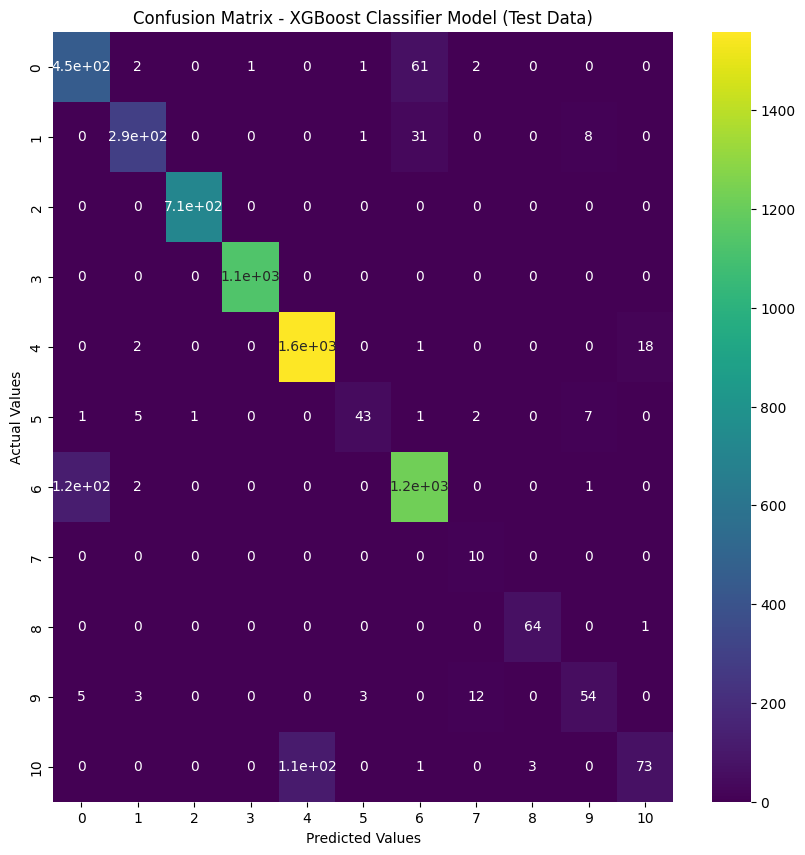

In [79]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - XGBoost Classifier Model (Test Data)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### The XGBoost Classifier performed somewhat worse than the Ensemble Model with test accuracy and f1 score ~93%.
- ### Classification heatmap demonstrates very good classification overall but a high degree of misclassifications predicting Class 0 for Class 6; and Class 4 for Class 10.
- ### This classifier had a smaller confusion issue predicting Class 6 for Classes 0 and 1.
- ### Similar to the Ensemble Model, Class 7 with least amount of support (10 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly 16 times.
- ### There are no classes correctly predicted every time for perfect precision, recall, and f1 scores like the other classifiers.
- ### There is extreme evidence of overfitting with near perfect metrics on the training data.

## Load and compare the Random Forest Classifier performance on the test data since it had high validation metrics with the lowest amount of overfitting

In [80]:
# load saved random forest classifier model
rfc_clf = pickle.load(open('./bin/tfidf/rfc_clf_trained.pkl', 'rb'))

In [81]:
y_pred_train_rfc = rfc_clf.predict(X_train)
y_pred_test_rfc = rfc_clf.predict(X_test)

In [82]:
results_rfc_train_acc = accuracy_score(y_train, y_pred_train_rfc)
results_rfc_test_acc = accuracy_score(y_test, y_pred_test_rfc)

results_rfc_train_f1 = f1_score(y_train, y_pred_train_rfc, average='weighted')
results_rfc_test_f1 = f1_score(y_test, y_pred_test_rfc, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(results_rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Test Dataset: {}".format(results_rfc_test_acc))
print("\n#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(results_rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Test Dataset: {}".format(results_rfc_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_test, y_pred_test_rfc)
cr_rfc = pd.DataFrame(classification_report(y_test, y_pred_test_rfc, zero_division=1, output_dict=True)).T
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.9716234710461038

Random Forest Classifier Accuracy on Test Dataset: 0.9539331448528189

#####################

Random Forest Classifier F1 Score on Train Dataset: 0.9734142325886591

Random Forest Classifier F1 Score on Test Dataset: 0.9539834379992791


,precision,recall,f1-score,support
0,0.959052,0.865759,0.910020,514.000000
1,0.653608,0.957704,0.776961,331.000000
2,1.000000,1.000000,1.000000,714.000000
3,1.000000,1.000000,1.000000,1128.000000
4,1.000000,0.986076,0.992989,1580.000000
5,0.074074,0.033333,0.045977,60.000000
6,1.000000,0.940432,0.969302,1343.000000
7,0.416667,1.000000,0.588235,10.000000
8,1.000000,1.000000,1.000000,65.000000
9,0.597222,0.558442,0.577181,77.000000


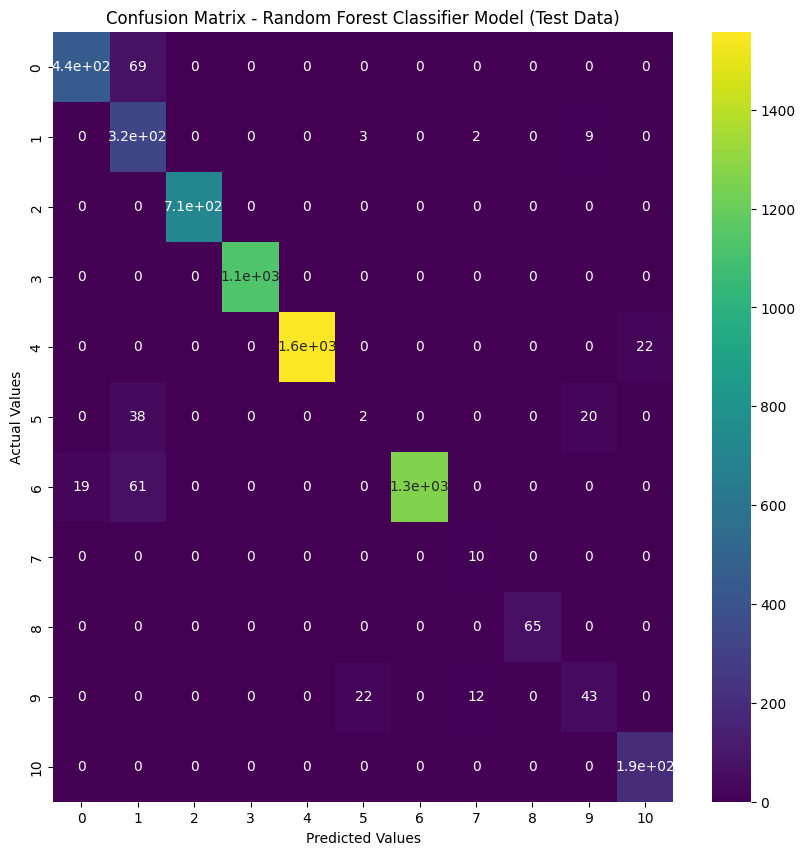

In [83]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Random Forest Classifier Model (Test Data)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### The Random Forest Classifier performed roughly the same as on the test data as it did on the validation data with test accuracy and f1 score ~95% which is a good indication of balanced bias-variance tradeoff.
- ### Classification heatmap demonstrates extremely good classification overall. 
- ### This classifier had some small confusion issues predicting Class 1 for Classes 0, 6, and 5; Class 5 for Class 9 (bidirectionally); and Class 10 for Class 4.
- ### Class 7 with least amount of support (10 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly 14 times.
- ### Class 2 (with 714 samples), Class 3 (with 1128 samples), and Class 8 (with 65 samples) were each correctly predicted every time for perfect precision, recall, and f1 scores.
- ### There is very slight evidence of overfitting with marginally higher metrics on the training data than the test data, however, this concern may be mollified by the classifier's similar performance on the validation and test datasets.

## Final Thoughts:
- ### Test dataset accuracy and f1 score for the Ensemble Model were very similar to the LightGBM Classifier's performance on the validation dataset, with associated marginal overfitting.  Further refinement and balancing would be helpful to mitigate the overfitting from the Ensemble Model before deployment.
- ### The XGBoost's lowered performance on the test dataset, when compared to the validation dataset, and high metrics on the training dataset indicate a high degree of overfitting.  Further hyperparameter tuning and evaluation would be helpful to mitigate the overfitting from the XGBoost Classifier before deployment
- ### The Random Forest Classifier had comparable accuracy and f1 scores on the test datasets as the Ensemble Model (without the same degree of overfitting to training data) and would be appropriate for deployment.  Furthermore, the Random Forest Classifier's similar performance on the validation and test data indicates a balanced bias-variance tradeoff.
- ### Evaluation of word embeddings with Gensim's Doc2Vec follows in notebook # 02.